# Carro Assignment

In [30]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay

import seaborn
import matplotlib.pyplot as plt

In [76]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

## Building and Cleaning the Database

First, let's import our first database, which includes advanced statistics of NFL Wide Receivers in 2019.

In [95]:
wr_db = pd.read_csv('FantasyPros_Fantasy_Football_Advanced_Stats_Report_WR_2019.csv')
wr_db

,Rank,Player,G,REC,YDS,Y/R,YBC,YBC/R,AIR,AIR/R,...,% TM,CATCHABLE,DROP,RZ TGT,10+ YDS,20+ YDS,30+ YDS,40+ YDS,50+ YDS,LNG
0,1.0,Michael Thomas (NO),16.0,149.0,"1,725",11.6,"1,142",7.7,"1,142",7.7,...,33.1%,157.0,6.0,22.0,73.0,17.0,5.0,3.0,0.0,49.0
1,2.0,Chris Godwin (TB),14.0,86.0,"1,333",15.5,756,8.8,756,8.8,...,19.9%,89.0,1.0,13.0,57.0,25.0,8.0,3.0,2.0,71.0
2,3.0,Kenny Golladay (NYG),16.0,65.0,"1,190",18.3,886,13.6,886,13.6,...,21.1%,71.0,6.0,15.0,43.0,22.0,12.0,6.0,3.0,75.0
3,4.0,Cooper Kupp (LAR),16.0,94.0,"1,161",12.4,623,6.6,623,6.6,...,21.9%,98.0,3.0,18.0,41.0,21.0,5.0,4.0,3.0,66.0
4,5.0,Julio Jones (TB),15.0,99.0,"1,394",14.1,"1,030",10.4,"1,030",10.4,...,24.0%,108.0,4.0,16.0,62.0,21.0,8.0,3.0,2.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,192.0,Gunner Olszewski (PIT),8.0,2.0,34,17.0,18,9.0,18,9.0,...,0.8%,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,29.0
192,193.0,Ryan Grant (FA),2.0,4.0,14,3.5,9,2.3,9,2.3,...,1.8%,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0
193,194.0,Austin Carr (FA),7.0,1.0,9,9.0,5,5.0,5,5.0,...,0.7%,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This dataset has a lot of excess information that we don't quite need or want. I have selected some statistics that I think are most relevant and insightful.

In [115]:
wr_db = wr_db[["Rank", "Player", "REC", "YDS", "Y/R", "YAC/R", "TGT", "% TM", "RZ TGT"]]
wr_db = wr_db.rename(columns={'% TM': '%_TM','RZ TGT': 'RZ_TGT'})
wr_db

,Rank,Player,REC,YDS,Y/R,YAC/R,TGT,%_TM,RZ_TGT
0,1.0,Michael Thomas,149.0,"1,725",11.6,3.9,185.0,33.1%,22.0
1,2.0,Chris Godwin,86.0,"1,333",15.5,6.7,121.0,19.9%,13.0
2,3.0,Kenny Golladay,65.0,"1,190",18.3,4.7,116.0,21.1%,15.0
3,4.0,Cooper Kupp,94.0,"1,161",12.4,5.7,134.0,21.9%,18.0
4,5.0,Julio Jones,99.0,"1,394",14.1,3.7,157.0,24.0%,16.0
...,...,...,...,...,...,...,...,...,...
191,192.0,Gunner Olszewski,2.0,34,17.0,8.0,4.0,0.8%,0.0
192,193.0,Ryan Grant,4.0,14,3.5,1.3,9.0,1.8%,2.0
193,194.0,Austin Carr,1.0,9,9.0,4.0,4.0,0.7%,0.0
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, let's import our other database, which includes statistics of the same wide receivers in the same year, simply in a fantasy football context. The columns we want are the player, points, and their average points.

In [116]:
eos_ranks = pd.read_csv('wr_eos_rankings_2019.csv')
eos_ranks = eos_ranks[["Player", "Points", "Games", "Avg"]]
eos_ranks

,Player,Points,Games,Avg
0,Michael Thomas,374.6,16.0,23.4
1,Chris Godwin,276.1,14.0,19.7
2,Julio Jones,274.1,15.0,18.3
3,Cooper Kupp,270.5,16.0,16.9
4,DeAndre Hopkins,269.5,15.0,18.0
...,...,...,...,...
289,Quincy Enunwa,-1.4,1.0,-1.4
290,Greg Dortch,-2.0,2.0,-1.0
291,Ray-Ray McCloud,-2.0,6.0,-0.3
292,NaN,NaN,NaN,NaN


If we want to combine these two databases, we will need them to have a common column, which will be the player's name. However, we the advanced statistics database includes the player's team in their name. We can remove it so that the names match those in the other database.

In [117]:
wr_db['Player'] = wr_db['Player'].str.replace(r"\(.*\)","")
wr_db['Player'] = wr_db['Player'].str.strip()
wr_db

C:\Users\danie\AppData\Local\Temp\ipykernel_9712\240766539.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  wr_db['Player'] = wr_db['Player'].str.replace(r"\(.*\)","")


,Rank,Player,REC,YDS,Y/R,YAC/R,TGT,%_TM,RZ_TGT
0,1.0,Michael Thomas,149.0,"1,725",11.6,3.9,185.0,33.1%,22.0
1,2.0,Chris Godwin,86.0,"1,333",15.5,6.7,121.0,19.9%,13.0
2,3.0,Kenny Golladay,65.0,"1,190",18.3,4.7,116.0,21.1%,15.0
3,4.0,Cooper Kupp,94.0,"1,161",12.4,5.7,134.0,21.9%,18.0
4,5.0,Julio Jones,99.0,"1,394",14.1,3.7,157.0,24.0%,16.0
...,...,...,...,...,...,...,...,...,...
191,192.0,Gunner Olszewski,2.0,34,17.0,8.0,4.0,0.8%,0.0
192,193.0,Ryan Grant,4.0,14,3.5,1.3,9.0,1.8%,2.0
193,194.0,Austin Carr,1.0,9,9.0,4.0,4.0,0.7%,0.0
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we have to convert the numbers in the "Points" and "Avg" columns into floats, as they are currently strings.

In [118]:
eos_ranks['Points'] = eos_ranks['Points'].fillna(0).astype(float)
eos_ranks['Avg'] = eos_ranks['Avg'].fillna(0).astype(float)
eos_ranks

,Player,Points,Games,Avg
0,Michael Thomas,374.6,16.0,23.4
1,Chris Godwin,276.1,14.0,19.7
2,Julio Jones,274.1,15.0,18.3
3,Cooper Kupp,270.5,16.0,16.9
4,DeAndre Hopkins,269.5,15.0,18.0
...,...,...,...,...
289,Quincy Enunwa,-1.4,1.0,-1.4
290,Greg Dortch,-2.0,2.0,-1.0
291,Ray-Ray McCloud,-2.0,6.0,-0.3
292,NaN,0.0,NaN,0.0


Finally, we can merge the two dataframes on the "Player" column. The second dataframe has many names that are not included in the first, and these can be distinguished by whether or not they have a cell that has NaN.

In [119]:
merged = pd.merge(wr_db, eos_ranks, on='Player')
merged = merged.dropna()
merged

,Rank,Player,REC,YDS,Y/R,YAC/R,TGT,%_TM,RZ_TGT,Points,Games,Avg
0,1.0,Michael Thomas,149.0,"1,725",11.6,3.9,185.0,33.1%,22.0,374.6,16.0,23.4
1,2.0,Chris Godwin,86.0,"1,333",15.5,6.7,121.0,19.9%,13.0,276.1,14.0,19.7
2,3.0,Kenny Golladay,65.0,"1,190",18.3,4.7,116.0,21.1%,15.0,248.0,16.0,15.5
3,4.0,Cooper Kupp,94.0,"1,161",12.4,5.7,134.0,21.9%,18.0,270.5,16.0,16.9
4,5.0,Julio Jones,99.0,"1,394",14.1,3.7,157.0,24.0%,16.0,274.1,15.0,18.3
...,...,...,...,...,...,...,...,...,...,...,...,...
189,190.0,Bobo Wilson,3.0,35,11.7,1.0,11.0,1.8%,0.0,4.5,6.0,0.8
190,191.0,Mike Thomas,2.0,14,7.0,5.0,5.0,0.8%,0.0,3.4,16.0,0.2
191,192.0,Gunner Olszewski,2.0,34,17.0,8.0,4.0,0.8%,0.0,3.4,8.0,0.4
192,193.0,Ryan Grant,4.0,14,3.5,1.3,9.0,1.8%,2.0,5.4,2.0,2.7


## Takeaways from the Data

This data can give us a lot of insight into how Wide Receivers in the NFL fared in the 2019 NFL season. Let's find some useful information from the dataframe. First, we'll find the top 10 receivers in total points scored.

In [120]:
%sql SELECT Player, Points FROM merged ORDER BY Points DESC LIMIT 10;

,Player,Points
0,Michael Thomas,374.6
1,Chris Godwin,276.1
2,Julio Jones,274.1
3,Cooper Kupp,270.5
4,DeAndre Hopkins,269.5
5,Keenan Allen,261.5
6,Julian Edelman,256.3
7,Allen Robinson II,254.9
8,Kenny Golladay,248.0
9,Amari Cooper,246.5


We will now get the receivers that had more than 100 targets with a catch rate of at least 65%.

In [126]:
%sql SELECT Player, REC/TGT FROM merged WHERE "TGT" > 100 AND ("REC" / "TGT") >= 0.65;

,Player,"(""REC"" / ""TGT"")"
0,Michael Thomas,0.805405
1,Chris Godwin,0.710744
2,Cooper Kupp,0.701493
3,Amari Cooper,0.663866
4,DeAndre Hopkins,0.693333
5,Keenan Allen,0.697987
6,Julian Edelman,0.653595
7,Tyler Lockett,0.745455
8,Davante Adams,0.653543
9,Larry Fitzgerald,0.688073


Let's obtain the average points per game for players with at least 50 targets and 10 red zone targets.

In [129]:
%sql SELECT AVG(Points / Games) AS PPG FROM merged WHERE TGT >= 50 AND RZ_TGT >= 10;

,PPG
0,13.501629


We can also make a plot to find the distribution of total receptions for all receivers.

<AxesSubplot:>

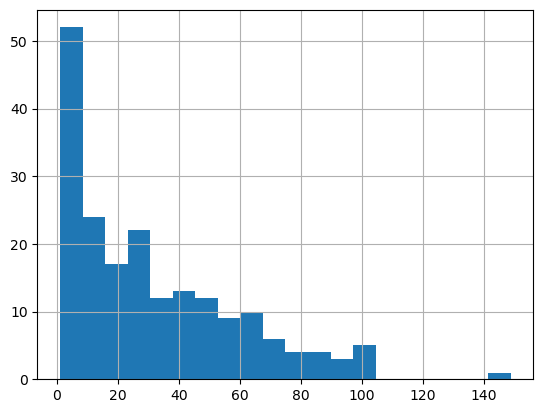

In [130]:
wr_db['REC'].hist(bins=20)

Let's see if there's a correlation between the Average Yards per Reception and the Number of Targets that a receiver gets.

Text(0, 0.5, 'Average Yards per Reception')

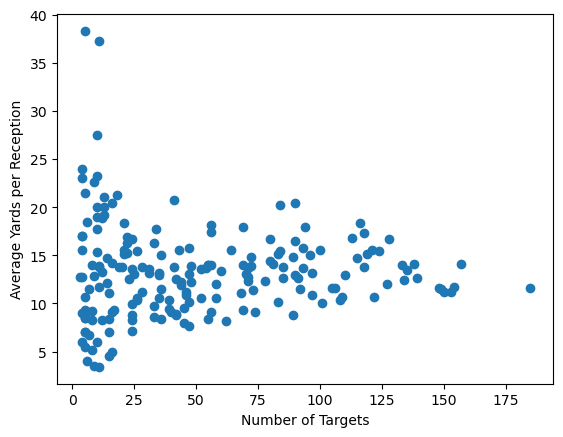

In [131]:
plt.scatter(wr_db['TGT'], wr_db['Y/R'])
plt.xlabel('Number of Targets')
plt.ylabel('Average Yards per Reception')